In [59]:
from setup_face import FACE
from utils import prepare_data
from worker import AEDetector, SimpleReformer, IdReformer, AttackData, Classifier, Operator, Evaluator
import utils
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import scipy.io
import copy
import pandas as pd

In [2]:
adv_robust_root_path = os.path.join("..", "adv_robust")
import sys
# include parent dir in the python search path
sys.path.append(adv_robust_root_path)
import fig_utils as u
import gllim

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [40]:
def transform_data(d, img_dim=32):
    n = d.shape[1]
    return np.transpose(copy.deepcopy(d)).reshape([n, img_dim, img_dim, 1])
def transform_back(x, vec_size=1024):
    n = x.shape[0]
    return np.transpose(copy.deepcopy(x).reshape(n, vec_size))

In [60]:
data_root_path = os.path.join(adv_robust_root_path, "tf_autozoom_2d_randVec20")
cluster_data_folder = os.path.join(adv_robust_root_path, "tf_autozoom_2d_randVec20_cluster")
# read in adversarial results for training data
data_path = os.path.join(data_root_path, "all_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
df_train = d["df"]
true_train_x = d["true_x"]
true_train_y = d["true_y"]
adv_train_x = d["adv_x"]
diff_train_x = adv_train_x - true_train_x
orig_pred_train = d["orig_pred"]
adv_pred_train = d["adv_pred"]

# read in adversarial results for testing data
data_path = os.path.join(data_root_path, "all_test_results.pkl")
with open(data_path, "rb") as f:
    d = pickle.load(f)
df_test = d["df"]
true_test_x = d["true_x"]
true_test_y = d["true_y"]
adv_test_x = d["adv_x"]
diff_test_x = adv_test_x - true_test_x
orig_pred_test = d["orig_pred"]
adv_pred_test = d["adv_pred"]

df = pd.concat([df_train, df_test])
df.head()

,img_idx,data_idx,data_type,loss,pred_loss,eps,eps_norm,orig_pred_loss,adv_pred_loss,noise_pred_loss,...,orig_pred_1,orig_pred_2,orig_pred_3,adv_pred_1,adv_pred_loss_1,adv_pred_loss_2,adv_pred_loss_3,diff_1,diff_2,diff_3
0,0,0,train,-0.064435,0.066060,1.040247,0.000996,0.001474,0.066060,0.001344,...,0.046382,-0.672185,-0.127650,-0.332950,0.000573,0.011838,0.053649,-0.014988,0.082319,-0.205300
1,1,1,train,-0.196822,0.197638,1.044288,0.000998,0.002536,0.197638,0.002167,...,0.409840,0.732874,-0.353605,-0.614667,0.102489,0.000069,0.095080,-0.303899,-0.002367,-0.261061
2,2,2,train,-0.043766,0.045398,1.044380,0.000998,0.000111,0.045398,0.000633,...,0.075148,-0.594922,0.180943,0.044872,0.003106,0.023219,0.019073,-0.051829,0.142791,-0.136071
4,4,3,train,-0.093389,0.094207,1.046704,0.000999,0.003173,0.094207,0.004603,...,-1.118577,-0.923481,1.719315,1.802744,0.078432,0.001062,0.014714,-0.239068,0.024939,0.083429
5,5,4,train,-0.118056,0.118464,1.045990,0.000999,0.000378,0.118464,0.000578,...,-0.188037,1.502874,0.726402,0.836998,0.099570,0.004198,0.014696,0.301696,-0.056262,0.110596


In [125]:
detector_I = AEDetector("./defensive_models/FACEADV_I", p=2)
detector_II = AEDetector("./defensive_models/FACE_II", p=1)
reformer = SimpleReformer("./defensive_models/FACE_I")

In [79]:
data = FACE()

In [98]:
model = gllim.GLLiM_np(os.path.join(adv_robust_root_path, "test_code", "face_model.mat"))
Lt = 3
model.set_Lt(Lt)
model.get_ths()

[GLLiM] Numpy version
[GLLiM] load model: ..\adv_robust\test_code\face_model.mat
[GLLiM] parameters: K: 20, L: 12, cstr.Sigma: i*
[GLLiM] set Lt: 3


In [119]:
orig = np.concatenate((data.test_data, data.test_adv), axis=0)
orig_y = np.concatenate((data.test_labels, data.test_labels), axis=1)
heal = reformer.heal(orig)

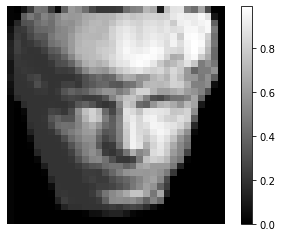

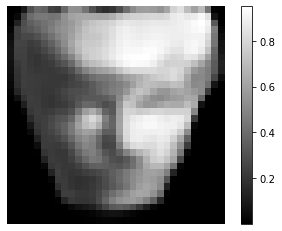

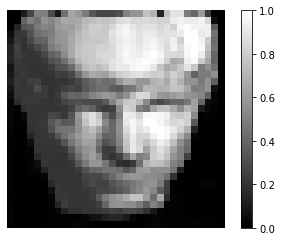

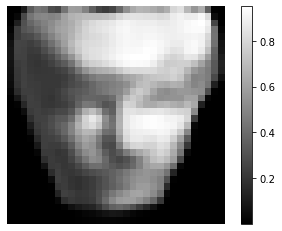

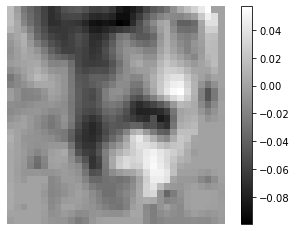

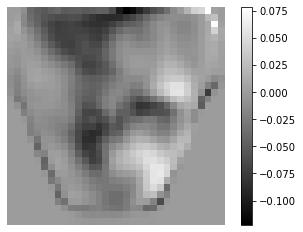

In [100]:
target_id = 6
u.plot_img(orig[target_id, :, :, :].squeeze())
u.plot_img(heal[target_id, :, :, :].squeeze())
u.plot_img(orig[target_id + 100, :, :, :].squeeze())
u.plot_img(heal[target_id + 100, :, :, :].squeeze())
u.plot_img(orig[target_id, :, :, :].squeeze() - orig[target_id+100, :, :, :].squeeze())
u.plot_img(heal[target_id, :, :, :].squeeze() - heal[target_id+100, :, :, :].squeeze())

In [83]:
orig_vec = transform_back(orig)
heal_vec = transform_back(heal)

orig_pred, _, _ = model.predict(orig_vec)
heal_pred, _, _ = model.predict(heal_vec)

In [120]:
# sanity check for the prediction errors
orig_sse = np.sum((orig_pred - orig_y)**2, axis=0)

(array([54., 24.,  5.,  9.,  4.,  2.,  0.,  1.,  0.,  1.]),
 array([0.03769805, 0.18614973, 0.33460141, 0.48305308, 0.63150476,
        0.77995644, 0.92840811, 1.07685979, 1.22531147, 1.37376314,
        1.52221482]),
 <a list of 10 Patch objects>)

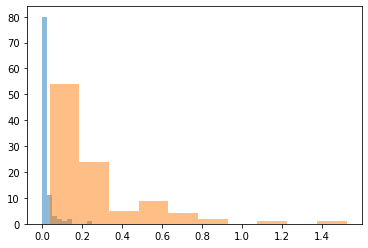

In [122]:
plt.hist(orig_sse[:100], alpha=0.5, label='x')
plt.hist(orig_sse[100:], alpha=0.5, label='y')

In [101]:
# different between orig and heal
diff = orig_pred - heal_pred
print(diff[:, target_id])
print(diff[:, target_id+100])

[-0.04516564 -0.00485675 -0.08083274]
[-0.05009436 -0.00168532 -0.09151196]


In [102]:
sse = np.sum(diff**2, axis=0)

In [103]:
orig_pred[:, target_id+100]

array([0.20553836, 0.33725717, 0.41042848])

(array([87.,  3.,  4.,  1.,  3.,  0.,  1.,  0.,  0.,  1.]),
 array([4.15526253e-05, 1.33327312e-02, 2.66239099e-02, 3.99150885e-02,
        5.32062671e-02, 6.64974457e-02, 7.97886244e-02, 9.30798030e-02,
        1.06370982e-01, 1.19662160e-01, 1.32953339e-01]),
 <a list of 10 Patch objects>)

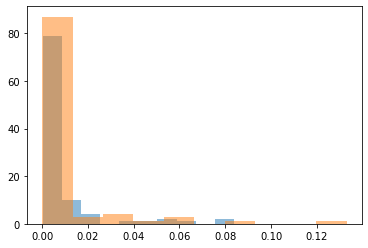

In [104]:
plt.hist(sse[:100], alpha=0.5, label='x')
plt.hist(sse[100:], alpha=0.5, label='y')

In [105]:
temp = sse.reshape([2, 100])

In [56]:
temp

array([[1.28504534e-03, 7.73914319e-03, 7.88618864e-03, 4.38323076e-02,
        1.80636965e-02, 1.47794733e-02, 3.13558766e-03, 2.11093263e-03,
        1.05892222e-02, 4.54088177e-03, 1.04762115e-02, 1.73853296e-02,
        3.98125250e-03, 8.37026985e-03, 9.91152288e-02, 1.77958691e-02,
        4.58646541e-03, 1.50528259e-03, 3.24369793e-02, 1.11234553e-01,
        8.90782938e-04, 9.54386306e-03, 1.97233506e-02, 3.86440580e-03,
        1.47206414e-02, 7.93349547e-02, 6.47637068e-03, 1.58063799e-02,
        4.64545066e-02, 1.26300181e-02, 5.92377049e-03, 1.14249920e-02,
        2.85497272e-02, 9.67882853e-03, 1.10842925e-03, 1.56319089e-01,
        1.69488245e-02, 3.29083974e-02, 1.25523171e-02, 3.40390924e-02,
        2.68733350e-02, 9.08886842e-03, 5.51846485e-03, 3.24179577e-03,
        2.36606707e-02, 4.15957664e-03, 1.17978110e-03, 1.52745404e-02,
        1.77955997e-02, 1.83528592e-03, 1.87255384e-03, 9.13452935e-03,
        3.22912485e-03, 9.73361373e-04, 1.15859937e-01, 9.235521

# Use reconstruct errors

(array([ 5.,  8., 20., 22., 17., 12.,  9.,  3.,  2.,  2.]),
 array([1.14717629, 1.50573292, 1.86428956, 2.22284619, 2.58140283,
        2.93995946, 3.2985161 , 3.65707273, 4.01562936, 4.374186  ,
        4.73274263]),
 <a list of 10 Patch objects>)

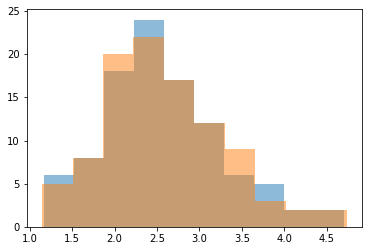

In [106]:
rec_err = np.sum((heal_vec - orig_vec)**2, axis=0)

plt.hist(rec_err[:100], alpha=0.5, label='x')
plt.hist(rec_err[100:], alpha=0.5, label='y')

In [96]:
print(rec_err[2])
print(rec_err[2 + 100])

2.350412044852183
2.3000071600833514


In [126]:
d1_mark = detector_I.mark(orig)
d2_mark = detector_II.mark(orig)

In [127]:
print(d1_mark[4])
print(d1_mark[4+100])

0.0018097345380435575
0.0017264712269128507


(array([ 4., 18., 23., 17., 18., 11.,  4.,  1.,  2.,  2.]),
 array([0.00086092, 0.00107816, 0.00129539, 0.00151263, 0.00172986,
        0.0019471 , 0.00216434, 0.00238157, 0.00259881, 0.00281604,
        0.00303328]),
 <a list of 10 Patch objects>)

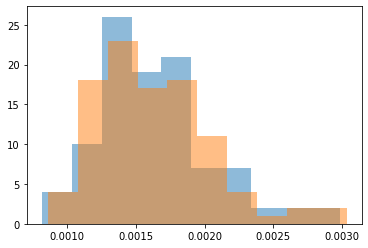

In [128]:
plt.hist(d1_mark[:100], alpha=0.5, label='x')
plt.hist(d1_mark[100:], alpha=0.5, label='y')

(array([19., 15., 15., 19.,  9.,  9.,  3.,  6.,  3.,  2.]),
 array([0.15114635, 0.17050027, 0.18985418, 0.2092081 , 0.22856201,
        0.24791592, 0.26726984, 0.28662375, 0.30597767, 0.32533158,
        0.3446855 ]),
 <a list of 10 Patch objects>)

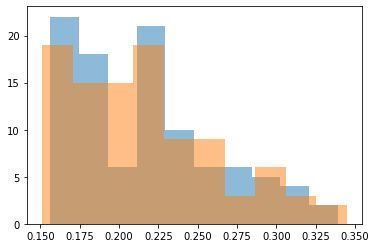

In [124]:
plt.hist(d2_mark[:100], alpha=0.5, label='x')
plt.hist(d2_mark[100:], alpha=0.5, label='y')

# Use GLLiM as autoencoder?

In [66]:
orig_all = model.predict_all(orig_vec)

[GLLiM NP]: Inverse prediction using cluster: 3
[-1.04970738  1.48574663 -1.56164592 -1.42756079 -0.5565278   0.42577144
  1.24852322 -0.69446049  0.97829727  0.66727223 -0.10300023 -1.45089125]
[-1.04965437  1.4857345  -1.56125481 -1.4268621  -0.55638565  0.42514217
  1.24688631 -0.69275256  0.97635982  0.66579286 -0.10306863 -1.44681206]
0.10645243785640886


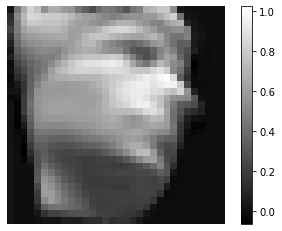

In [164]:
target_id = 0
temp = df.loc[(df["data_type"]=="test") & (df["data_idx"]==target_id), ["orig_p1"]]
target_cluster = int(temp["orig_p1"])
temp_pred = orig_all[:, target_id]
temp_pred_img = model.inverse_predict_cluster(temp_pred, target_cluster)
u.plot_img(temp_pred_img.squeeze())
pred_2 = model.predict_all(temp_pred_img.reshape([1024, 1]))
print(temp_pred.squeeze())
print(pred_2.squeeze())
print(np.linalg.norm(orig_vec[:, target_id] - temp_pred_img.reshape(-1))/np.linalg.norm(orig_vec[:, target_id]))

[GLLiM NP]: Inverse prediction using cluster: 3
[-1.15284114  1.57426264 -1.30018382 -1.65962269 -0.79092953  0.20627188
  1.26745521 -0.24523114  0.82465963  0.65730541 -0.38384067 -1.32215096]
[-1.15259728  1.57406898 -1.30006985 -1.65851372 -0.79023793  0.20636196
  1.26574601 -0.2449666   0.82332189  0.65558972 -0.38277552 -1.31869513]
0.10823813608191177


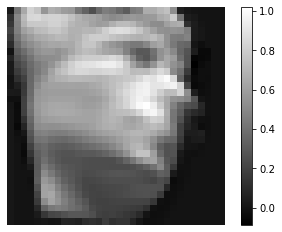

In [166]:
temp_pred = orig_all[:, target_id+100]
temp_pred_img = model.inverse_predict_cluster(temp_pred, target_cluster)
u.plot_img(temp_pred_img.squeeze())
pred_2 = model.predict_all(temp_pred_img.reshape([1024, 1]))
print(temp_pred.squeeze())
print(pred_2.squeeze())
print(np.linalg.norm(orig_vec[:, target_id+100] - temp_pred_img.reshape(-1))/np.linalg.norm(orig_vec[:, target_id+100]))

# Get gllim reconstruct errors

In [152]:
pred_cluster = model.get_predict_cluster(orig_vec)

In [168]:
rec_rel_error = []

for i in range(200):
    target_cluster = pred_cluster[i]
    temp_pred = orig_all[:, i]
    temp_pred_img = model.inverse_predict_cluster(temp_pred, target_cluster)
    rel_err = np.linalg.norm(orig_vec[:, i] - temp_pred_img.reshape(-1))/np.linalg.norm(orig_vec[:, i])
    rec_rel_error.append(rel_err)

[GLLiM NP]: Inverse prediction using cluster: 3
[GLLiM NP]: Inverse prediction using cluster: 16
[GLLiM NP]: Inverse prediction using cluster: 7
[GLLiM NP]: Inverse prediction using cluster: 8
[GLLiM NP]: Inverse prediction using cluster: 1
[GLLiM NP]: Inverse prediction using cluster: 12
[GLLiM NP]: Inverse prediction using cluster: 6
[GLLiM NP]: Inverse prediction using cluster: 11
[GLLiM NP]: Inverse prediction using cluster: 0
[GLLiM NP]: Inverse prediction using cluster: 15
[GLLiM NP]: Inverse prediction using cluster: 16
[GLLiM NP]: Inverse prediction using cluster: 10
[GLLiM NP]: Inverse prediction using cluster: 6
[GLLiM NP]: Inverse prediction using cluster: 16
[GLLiM NP]: Inverse prediction using cluster: 2
[GLLiM NP]: Inverse prediction using cluster: 4
[GLLiM NP]: Inverse prediction using cluster: 10
[GLLiM NP]: Inverse prediction using cluster: 11
[GLLiM NP]: Inverse prediction using cluster: 7
[GLLiM NP]: Inverse prediction using cluster: 10
[GLLiM NP]: Inverse prediction

(array([ 3., 10., 21., 17., 20., 16.,  8.,  3.,  1.,  1.]),
 array([0.04300641, 0.06645589, 0.08990538, 0.11335486, 0.13680434,
        0.16025383, 0.18370331, 0.2071528 , 0.23060228, 0.25405177,
        0.27750125]),
 <a list of 10 Patch objects>)

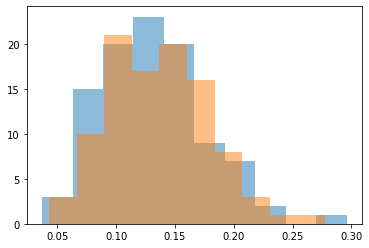

In [169]:
plt.hist(rec_rel_error[:100], alpha=0.5, label='x')
plt.hist(rec_rel_error[100:], alpha=0.5, label='y')

In [74]:
pred_2

array([[ 0.43414434],
       [ 0.3287856 ],
       [ 0.56232316],
       [-1.28843611],
       [ 0.22783881],
       [-0.774086  ],
       [-0.98355268],
       [ 0.09893813],
       [-0.46243041],
       [ 1.09885526],
       [ 0.1321861 ],
       [ 0.96476323]])

In [75]:
temp_pred

array([ 0.43379038,  0.3288438 ,  0.5622205 , -1.28902267,  0.2278089 ,
       -0.77507209, -0.98555903,  0.09874488, -0.46405358,  1.10274075,
        0.13298534,  0.9685711 ])

In [143]:
pred_cluster = model.get_predict_cluster(orig_vec)

In [147]:
cluster_list = []
for i in range(100):
    temp = df.loc[(df["data_type"]=="test") & (df["data_idx"]==i), ["orig_p1"]]
    target_cluster = int(temp["orig_p1"])
    cluster_list.append(target_cluster)

In [151]:
i = 0
for c1, c2 in zip(cluster_list, pred_cluster[100:]):
    print("{} {} {} {}".format(i, c1, c2, c1==c2))
    i += 1

0 3 3 True
1 16 16 True
2 7 7 True
3 8 8 True
4 1 17 False
5 12 12 True
6 6 6 True
7 11 11 True
8 0 0 True
9 15 15 True
10 16 16 True
11 10 10 True
12 6 6 True
13 16 16 True
14 2 2 True
15 4 4 True
16 10 10 True
17 11 11 True
18 7 7 True
19 10 10 True
20 2 2 True
21 1 1 True
22 12 12 True
23 16 8 False
24 7 7 True
25 14 14 True
26 6 6 True
27 7 7 True
28 14 14 True
29 6 6 True
30 11 11 True
31 7 7 True
32 12 12 True
33 3 3 True
34 19 19 True
35 5 5 True
36 1 1 True
37 16 16 True
38 13 13 True
39 12 12 True
40 12 12 True
41 0 0 True
42 11 11 True
43 17 17 True
44 17 17 True
45 3 3 True
46 5 5 True
47 4 4 True
48 14 14 True
49 6 6 True
50 11 11 True
51 16 16 True
52 6 6 True
53 6 6 True
54 4 4 True
55 0 0 True
56 2 2 True
57 16 16 True
58 16 16 True
59 8 8 True
60 18 18 True
61 3 3 True
62 1 1 True
63 5 5 True
64 13 13 True
65 1 1 True
66 12 12 True
67 7 7 True
68 16 16 True
69 9 9 True
70 4 4 True
71 14 14 True
72 9 9 True
73 6 6 True
74 7 7 True
75 5 5 True
76 14 14 True
77 2 2 True
78